<a href="https://colab.research.google.com/github/priyasea/MyMLProjectsPriya/blob/main/pytorch_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [4]:
import torch

In [5]:
from PIL import Image
import numpy as np

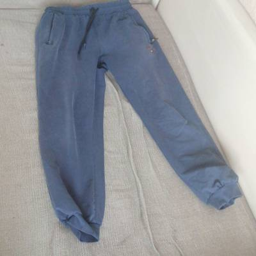

In [6]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img.resize((256, 256))

array([[[179, 181, 176],
        [179, 181, 176],
        [179, 181, 176],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[180, 181, 176],
        [177, 178, 173],
        [177, 178, 173],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [235, 228, 220]],

       [[178, 179, 174],
        [175, 176, 171],
        [175, 176, 171],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [234, 227, 219]],

       ...,

       [[155, 149, 137],
        [155, 149, 137],
        [158, 152, 140],
        ...,
        [157, 149, 138],
        [159, 151, 140],
        [156, 148, 137]],

       [[151, 145, 133],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [155, 147, 136],
        [157, 149, 138],
        [155, 147, 136]],

       [[150, 144, 132],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [154, 146, 135],
        [155, 147, 136],
        [153, 145, 134]]], dtype=uint8)
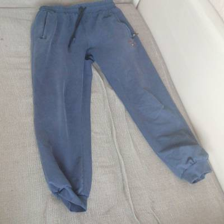

In [7]:
X = np.array(img.resize((224, 224)))

X

In [8]:
import torchvision.models as models
from torchvision import transforms

In [9]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval();

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 113MB/s] 


In [13]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [17]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

In [19]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


--2025-12-19 05:14:43--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2025-12-19 05:14:43 (7.31 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [20]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


In [21]:
import os
from torch.utils.data import Dataset

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [25]:
from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
import torch.nn as nn

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x